- O principal objetivo desse notebook é iniciar um estudo das vendas da EMPRESA para conseguir projetar o faturamento da empresa para os próximos 2 meses

# Imports

In [384]:
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

## Functions

In [385]:
def calculate_metrics(algorithm, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    dict = {
        'Algorithm': algorithm,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    return pd.DataFrame([dict])

# Data Load

In [386]:
order = pd.read_csv('../data/order.csv')

# 1.0 Descrição dos Dados

In [387]:
df1 = order.copy()

## 1.1 Dimensão dos Dados

In [388]:
df1.shape

(1000, 13)

## 1.2 Tipo dos Dados

In [389]:
df1.dtypes

OrderID            int64
CustomerID         int64
OrderDate         object
OrderStatus       object
ShippedDate       object
ShipAddress       object
Unnamed: 6       float64
Unnamed: 7       float64
Unnamed: 8       float64
ShipCountry       object
ShippingFee      float64
PaymentMethod     object
TotalAmount      float64
dtype: object

- Teremos que trocar o tipo dos dados de OrderDate e ShippedDate

## 1.3 Check NA

In [390]:
df1.isna().sum()

OrderID             0
CustomerID          0
OrderDate           0
OrderStatus         0
ShippedDate         0
ShipAddress         0
Unnamed: 6       1000
Unnamed: 7       1000
Unnamed: 8       1000
ShipCountry         0
ShippingFee         0
PaymentMethod       0
TotalAmount         0
dtype: int64

## 1.4 Change Data Type

In [391]:
df1['OrderDate'] = pd.to_datetime(df1['OrderDate'])

df1['ShippedDate'] = pd.to_datetime(df1['ShippedDate'])

df1.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True)

# 2.0 Feature Engineering

In [392]:
df2 = df1.copy()

In [393]:
df2['Year'] = df2['OrderDate'].dt.year
df2['Month'] = df2['OrderDate'].dt.month
df2['Year_Month'] = df2['OrderDate'].dt.to_period('M')

ts_sales = df2[['OrderDate', 'TotalAmount']].sort_values('OrderDate', ascending=True).set_index('OrderDate')

ts_sales['Mes'] = ts_sales.index.to_period('M').to_timestamp()

# Agora, agrupando por essa nova coluna
ts_sales_mes = ts_sales.groupby('Mes').sum()


# 3.0 Exploratory Data Analysis

In [394]:
df3 = df2.copy()

## Business Insights

### Faturamento ao longo do tempo

<Axes: title={'center': 'Faturamento por Ano'}, xlabel='Year', ylabel='TotalAmount'>

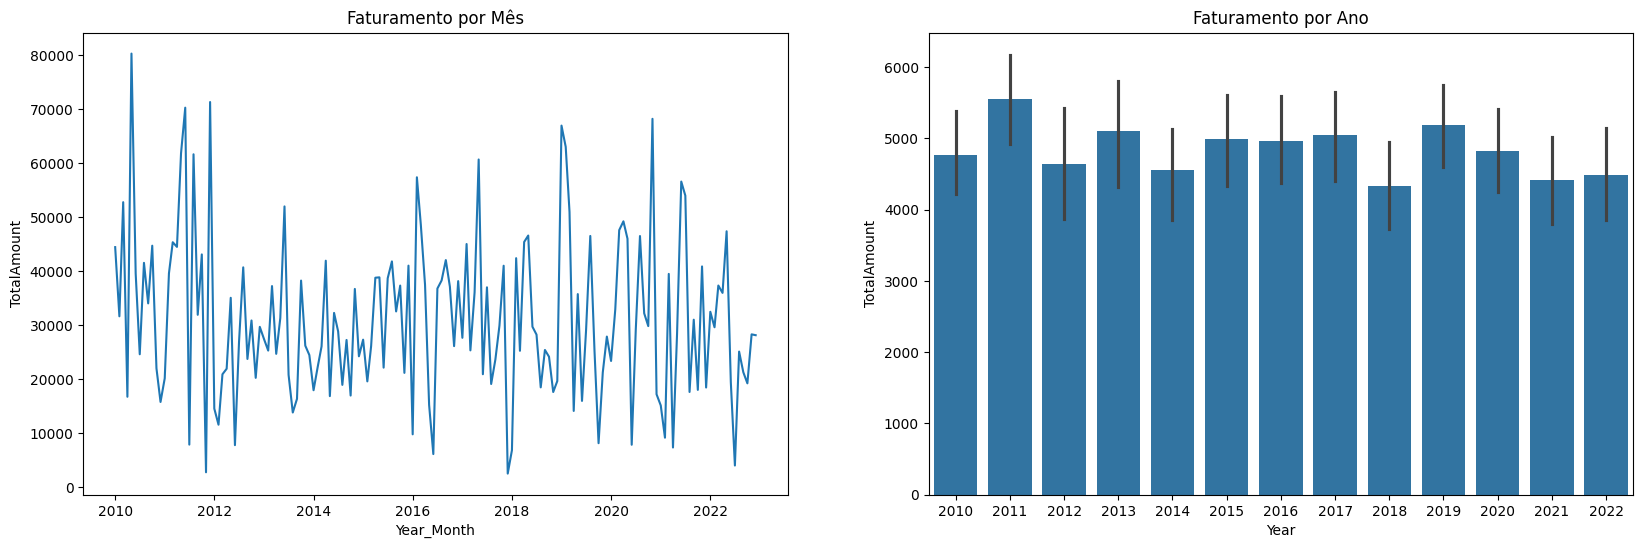

In [395]:
df_faturamento = df3.groupby(['Year_Month'])['TotalAmount'].sum().reset_index()
df_faturamento['Year_Month'] = df_faturamento['Year_Month'].dt.to_timestamp()

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Faturamento por Mês')
sns.lineplot(x='Year_Month', y='TotalAmount', data=df_faturamento)

plt.subplot(1,2,2)
plt.title('Faturamento por Ano')
sns.barplot(x='Year', y='TotalAmount', data=df3)

### Faturamento por País

<Axes: title={'center': 'Top 20 Países com maior faturamento'}, xlabel='ShipCountry', ylabel='TotalAmount'>

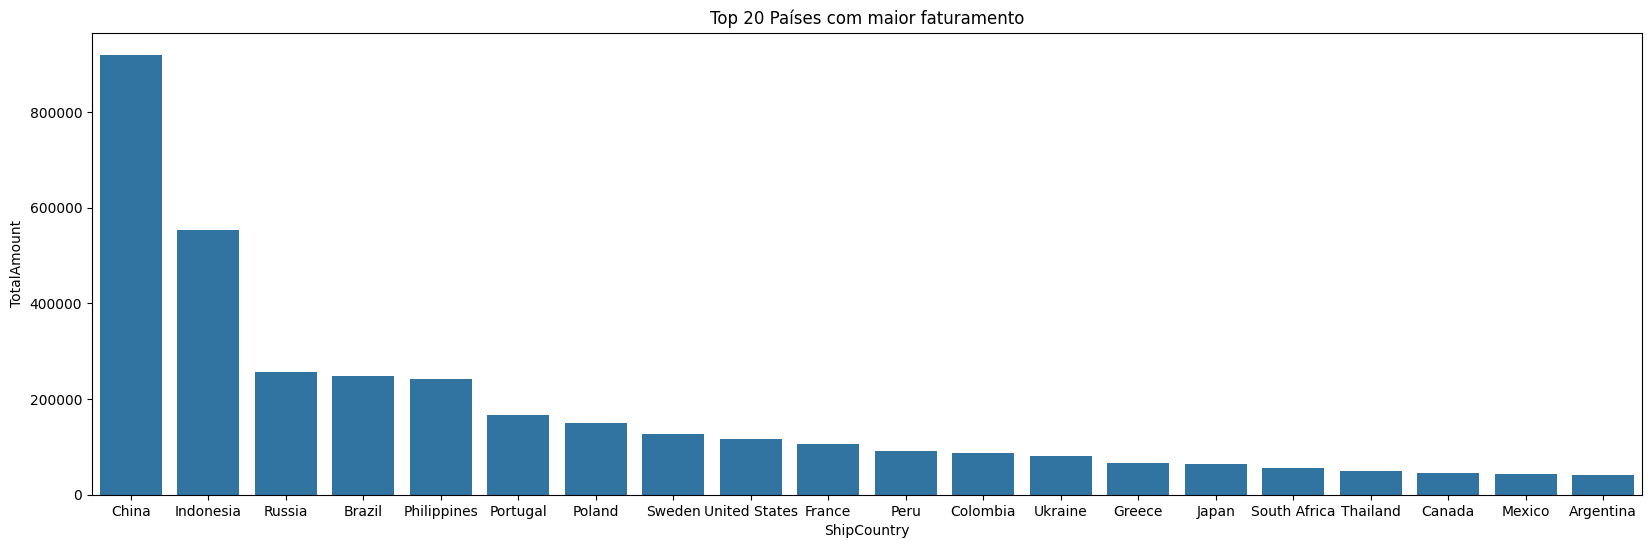

In [396]:

df_country = df3.groupby(['ShipCountry'])['TotalAmount'].sum().reset_index().sort_values('TotalAmount', ascending=False)

plt.figure(figsize=(20,6))
plt.title('Top 20 Países com maior faturamento')
sns.barplot(x='ShipCountry', y='TotalAmount', data=df_country.head(20))

### Faturamento por Tipo de Pagamento

<Axes: xlabel='PaymentMethod', ylabel='TotalAmount'>

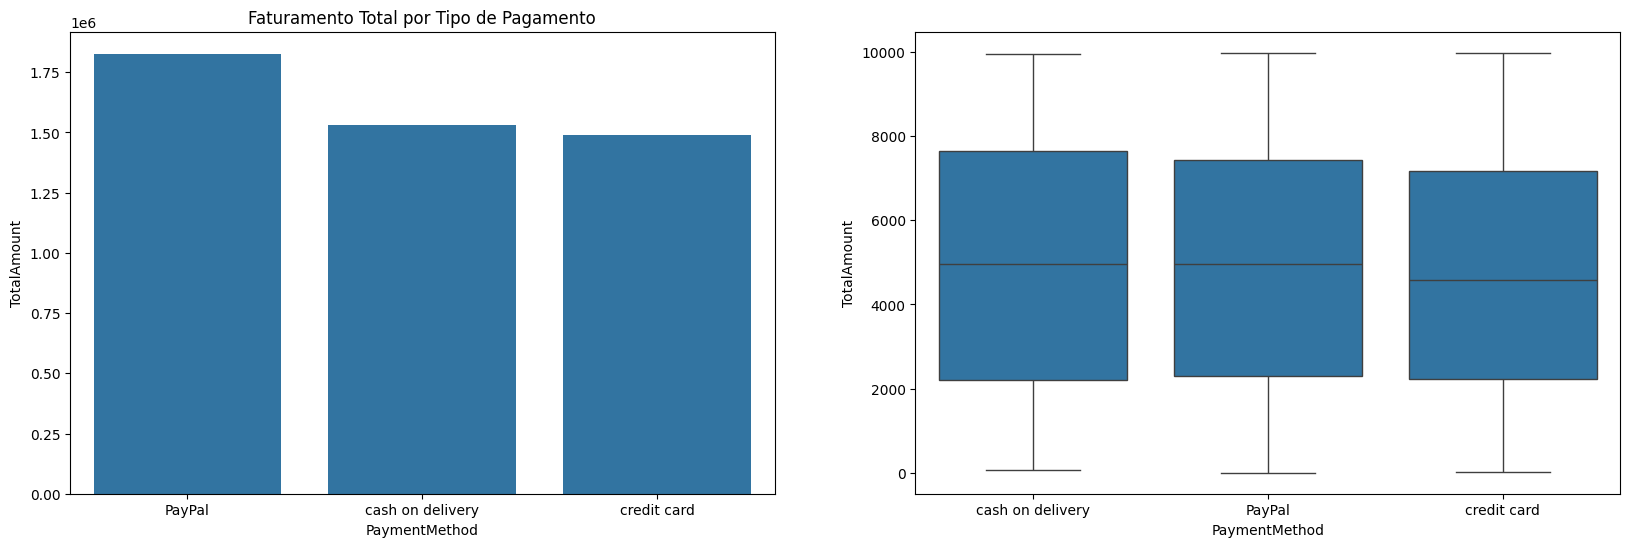

In [397]:

df_type = df3.groupby(['PaymentMethod'])['TotalAmount'].sum().reset_index().sort_values('TotalAmount', ascending=False)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Faturamento Total por Tipo de Pagamento')
sns.barplot(x='PaymentMethod', y='TotalAmount', data=df_type.head(20))

plt.subplot(1,2,2)
sns.boxplot(x='PaymentMethod', y='TotalAmount', data=df3)

### Análise por Status

<Axes: xlabel='OrderStatus', ylabel='TotalAmount'>

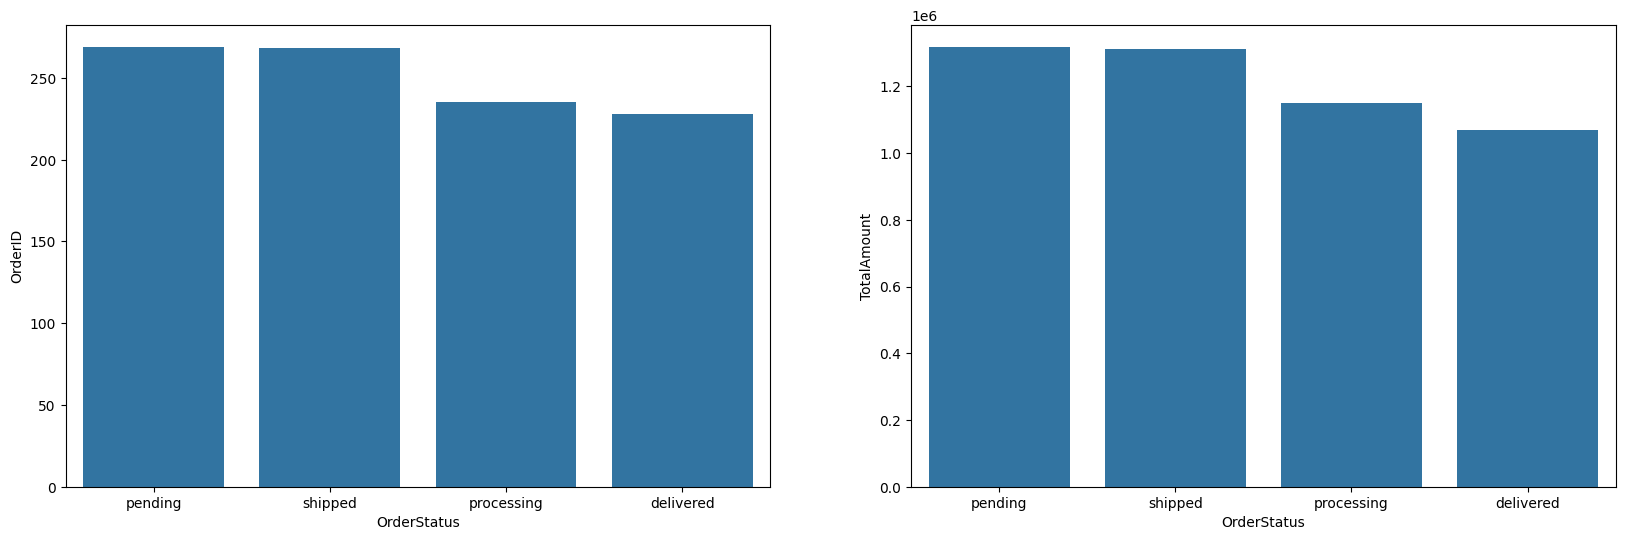

In [398]:
plt.figure(figsize=(20,6))

# quantidade de pedidos por status
orders_status = df3[['OrderID','OrderStatus']].groupby('OrderStatus').count().reset_index().sort_values('OrderID', ascending=False)
plt.subplot(1,2,1)
sns.barplot(x='OrderStatus', y='OrderID', data=orders_status)

# faturamento por status
faturamento_status = df3[['TotalAmount','OrderStatus']].groupby('OrderStatus').sum().reset_index().sort_values('TotalAmount', ascending=False)
plt.subplot(1,2,2)
sns.barplot(x='OrderStatus', y='TotalAmount', data=faturamento_status)



In [399]:
df3.head()

,OrderID,CustomerID,OrderDate,OrderStatus,ShippedDate,ShipAddress,ShipCountry,ShippingFee,PaymentMethod,TotalAmount,Year,Month,Year_Month
0,1,1,2012-02-16,pending,2021-07-10,30249 Donald Way,China,63.95,cash on delivery,1568.28,2012,2,2012-02
1,2,2,2012-02-06,processing,2014-06-23,97 David Street,Greece,75.62,cash on delivery,4654.31,2012,2,2012-02
2,3,3,2013-01-02,pending,2022-10-22,2024 Myrtle Parkway,Poland,453.17,PayPal,5810.01,2013,1,2013-01
3,4,4,2013-02-28,pending,2011-11-22,75158 Merry Plaza,Japan,883.25,PayPal,4388.28,2013,2,2013-02
4,5,5,2014-08-28,delivered,2017-08-16,875 Nancy Hill,Portugal,881.14,credit card,2972.23,2014,8,2014-08


## Time Series Analysis

<Axes: xlabel='Mes'>

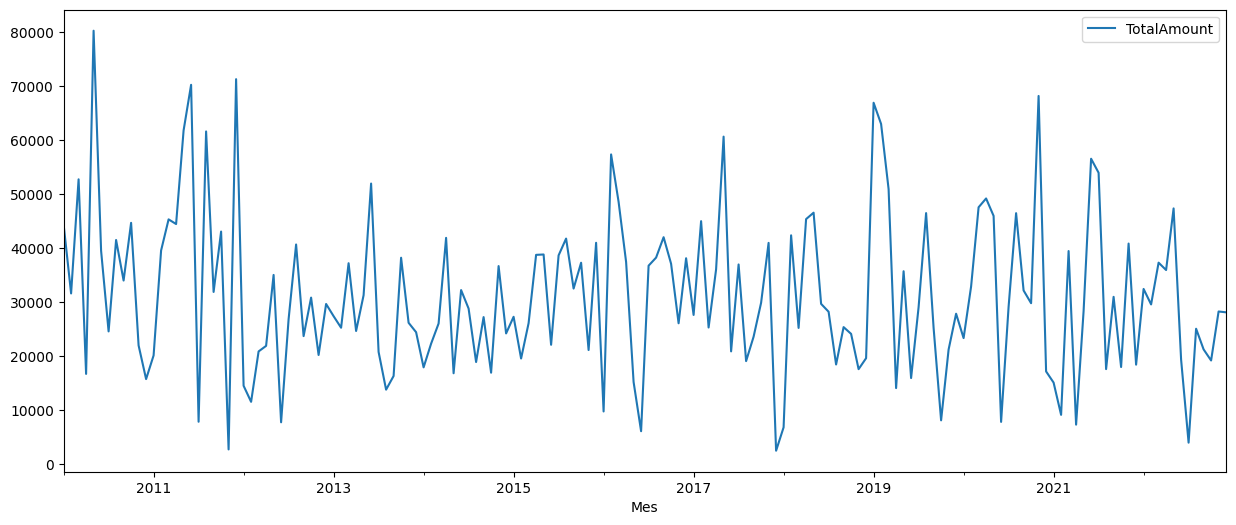

In [400]:
ts_sales_mes.plot(figsize=(15,6))

#### Média Móvel Simples (MMS)

<Axes: xlabel='Mes'>

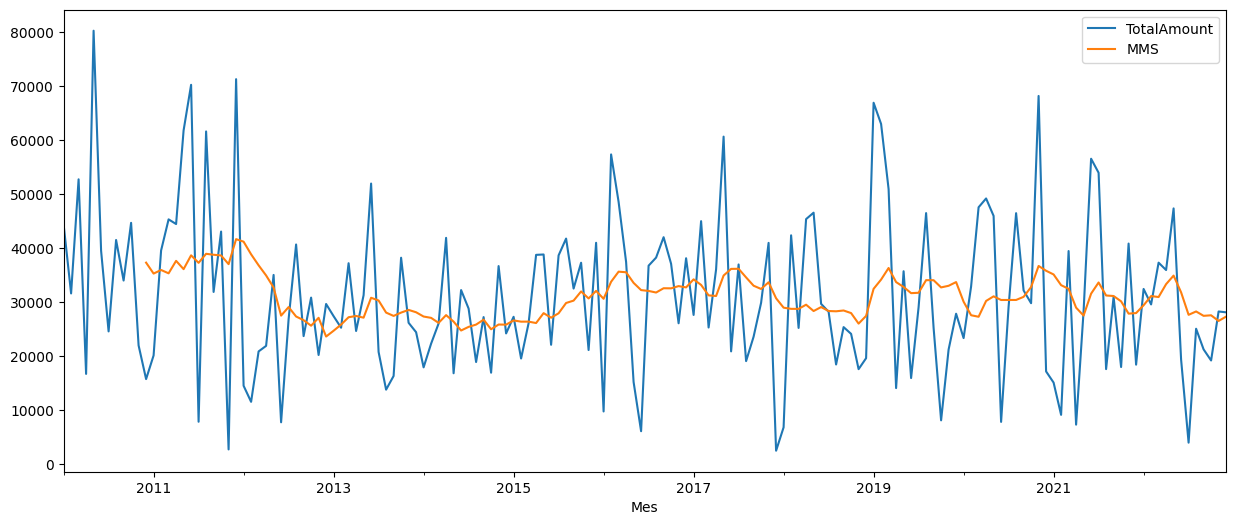

In [401]:
ts_aux = pd.DataFrame(ts_sales_mes['TotalAmount'])
ts_aux['MMS'] = ts_sales_mes.rolling(12).mean()['TotalAmount']

ts_aux.plot(figsize=(15,6))

<Axes: xlabel='OrderDate'>

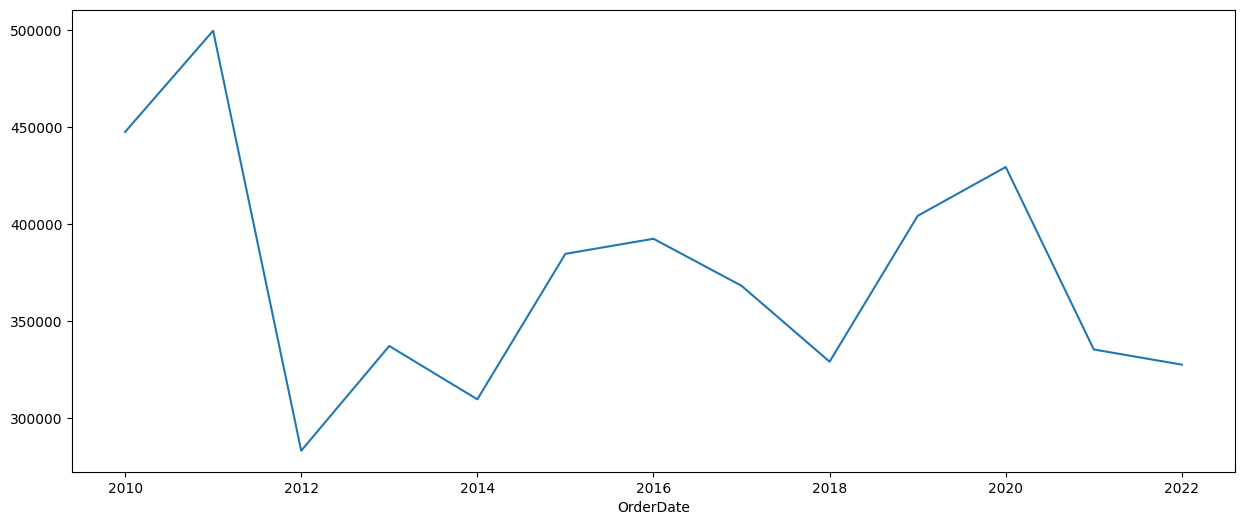

In [402]:
ts_sales.TotalAmount.groupby(ts_sales.index.year).sum().plot(figsize=(15, 6))

#### Análise de Sazonalidade

<Axes: xlabel='Mes'>

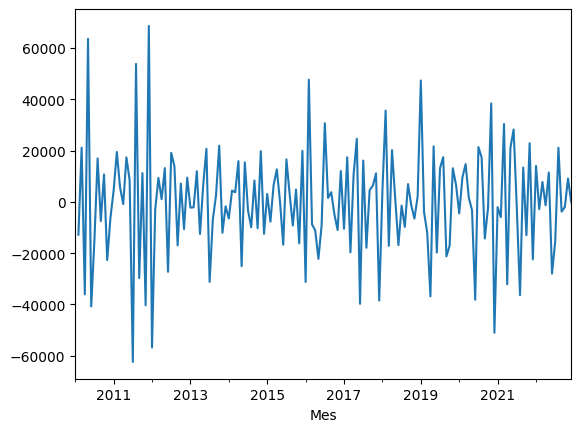

In [403]:
ts_sales_mes.TotalAmount.diff().plot()

<Axes: xlabel='Mes'>

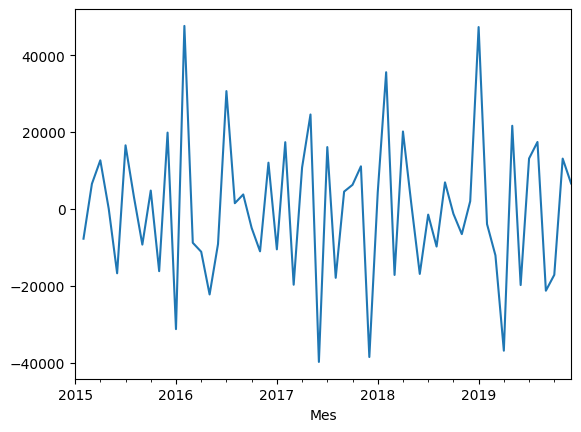

In [404]:
interval = (ts_sales_mes.index.year >= 2015) & (ts_sales_mes.index.year <= 2019)
ts_sales_mes[interval].TotalAmount.diff().plot()

<Axes: xlabel='Mes'>

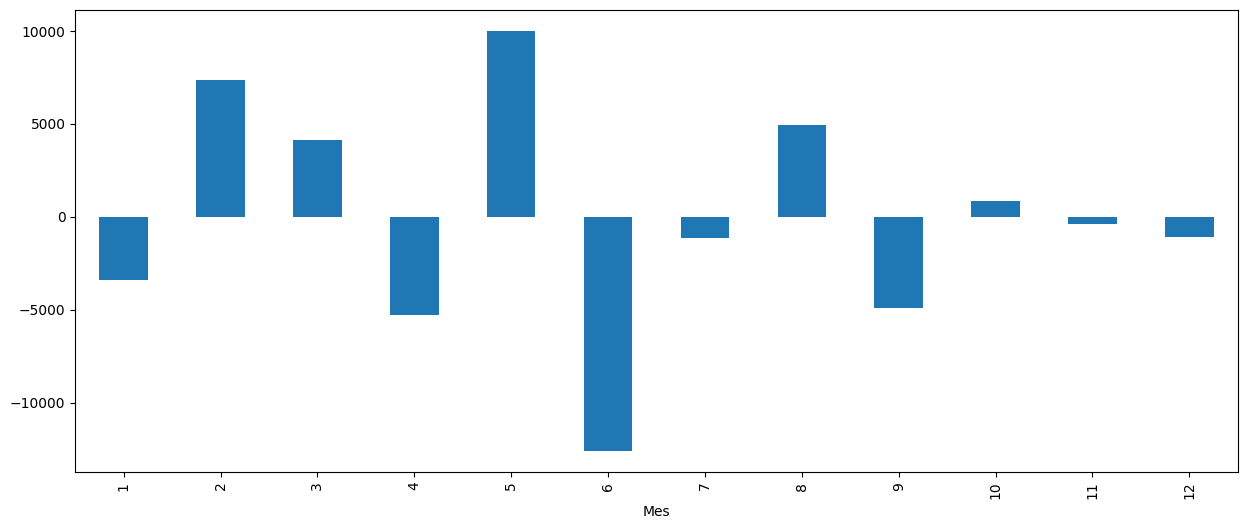

In [405]:
ts_sales_mes.TotalAmount.diff(1).groupby(ts_sales_mes.index.month).mean().plot(kind='bar', figsize=(15,6))

# Prediction Models

## Modelo Naive

In [406]:
ts_sales_mes['naive_prediction'] = ts_sales_mes.TotalAmount.shift(1)
ts_sales_mes

,TotalAmount,naive_prediction
Mes,,
2010-01-01,44405.90,NaN
2010-02-01,31596.22,44405.90
2010-03-01,52729.45,31596.22
2010-04-01,16699.42,52729.45
2010-05-01,80244.65,16699.42
...,...,...
2022-08-01,25064.17,3966.54
2022-09-01,21239.42,25064.17
2022-10-01,19183.93,21239.42


<Axes: xlabel='Mes'>

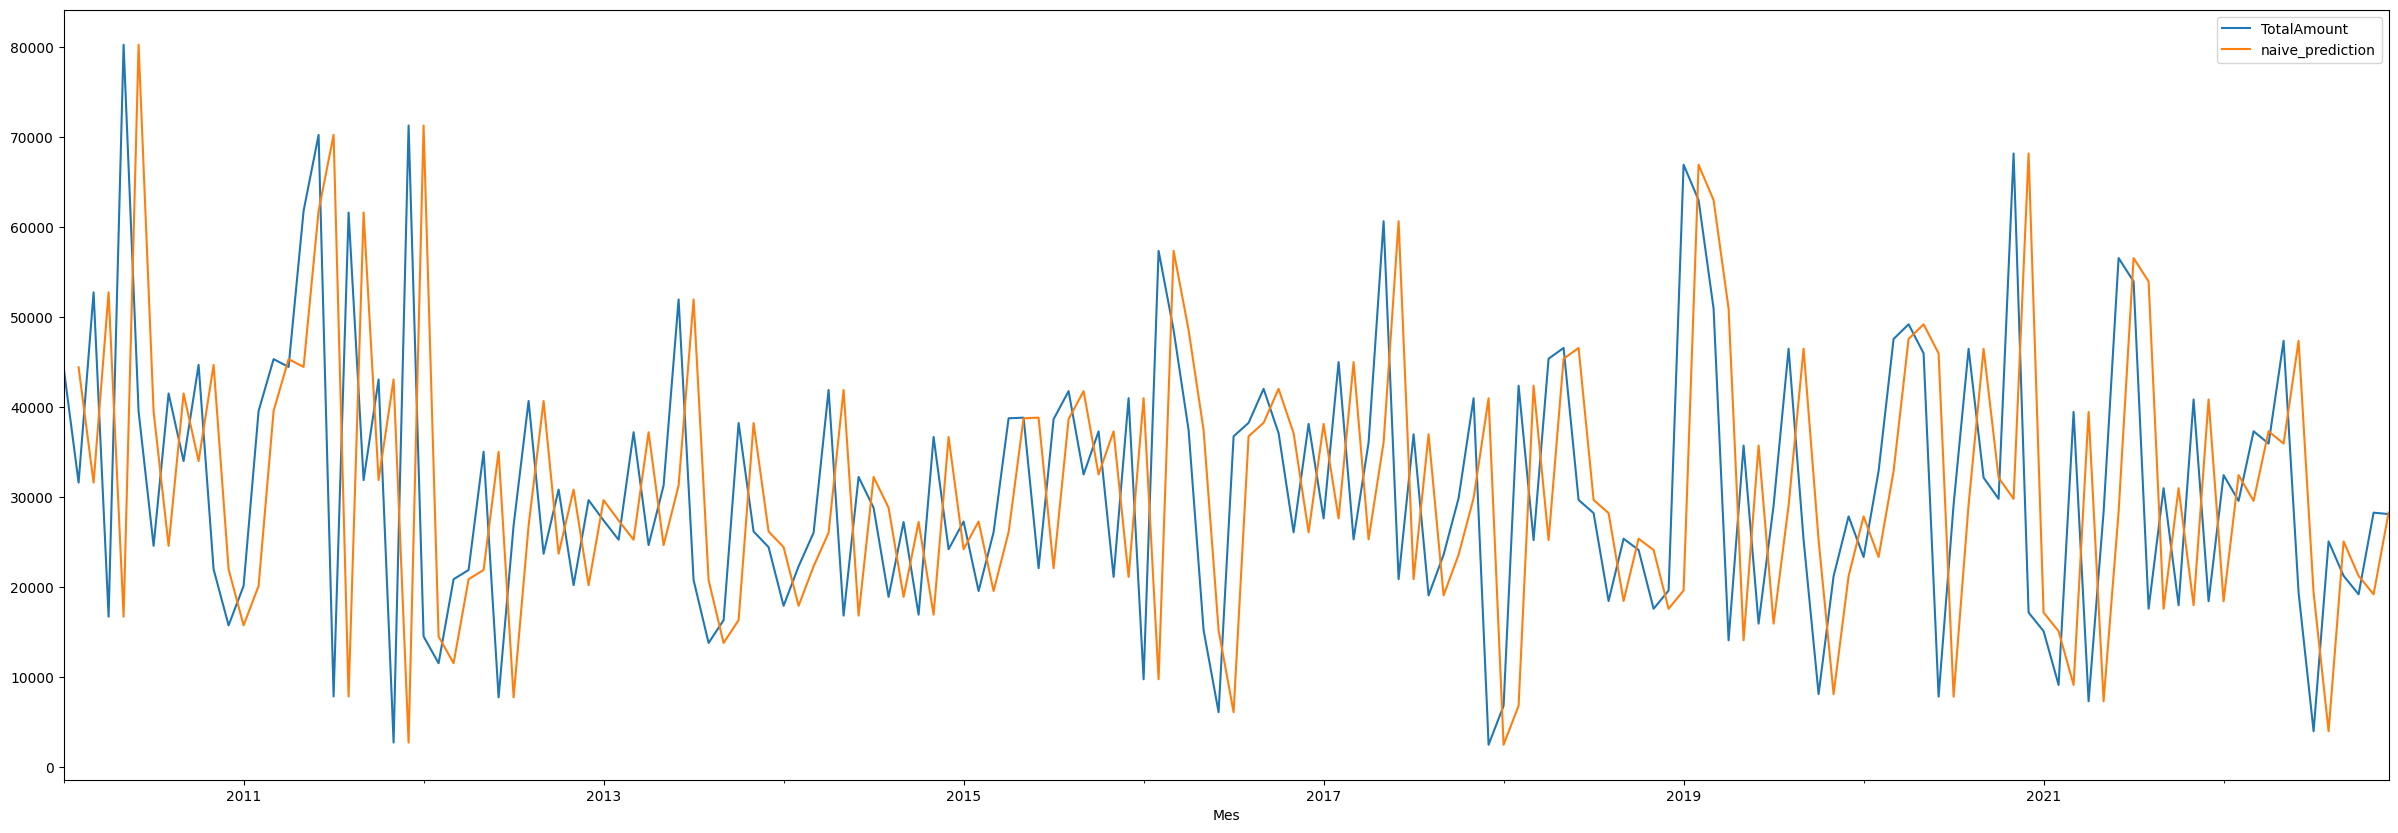

In [407]:
ts_sales_mes.plot(figsize=(30,10))

In [408]:
ts_sales_mes.dropna(subset=['TotalAmount', 'naive_prediction'], inplace=True)

naive_metrics = calculate_metrics('naive model', ts_sales_mes.TotalAmount, ts_sales_mes.naive_prediction)
naive_metrics

,Algorithm,MAE,RMSE,R2
0,naive model,15970.946774,21100.547723,-0.994176


## Autoregressive Model

In [409]:
from sklearn.linear_model import LinearRegression

In [410]:
ts_sales_mes = ts_sales_mes.drop('naive_prediction',axis=1)
ts_sales_mes['x1'] = ts_sales_mes.TotalAmount.shift(1)
ts_sales_mes.dropna(axis=0,inplace=True)
ts_sales_mes.head()

,TotalAmount,x1
Mes,,
2010-03-01,52729.45,31596.22
2010-04-01,16699.42,52729.45
2010-05-01,80244.65,16699.42
2010-06-01,39500.28,80244.65
2010-07-01,24566.94,39500.28


In [411]:
X = ts_sales_mes.x1.values
y = ts_sales_mes.TotalAmount.values


In [412]:
lr = LinearRegression()
lr.fit(X.reshape(-1,1),y)
y_pred = lr.predict(X.reshape(-1, 1))

lr_metrics = calculate_metrics('linear regression', ts_sales_mes.TotalAmount, y_pred)
lr_metrics

,Algorithm,MAE,RMSE,R2
0,linear regression,11904.410255,14990.271784,0.000027


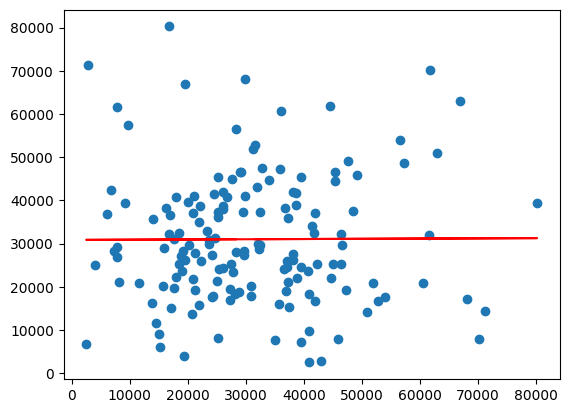

In [413]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')

<Axes: xlabel='Mes'>

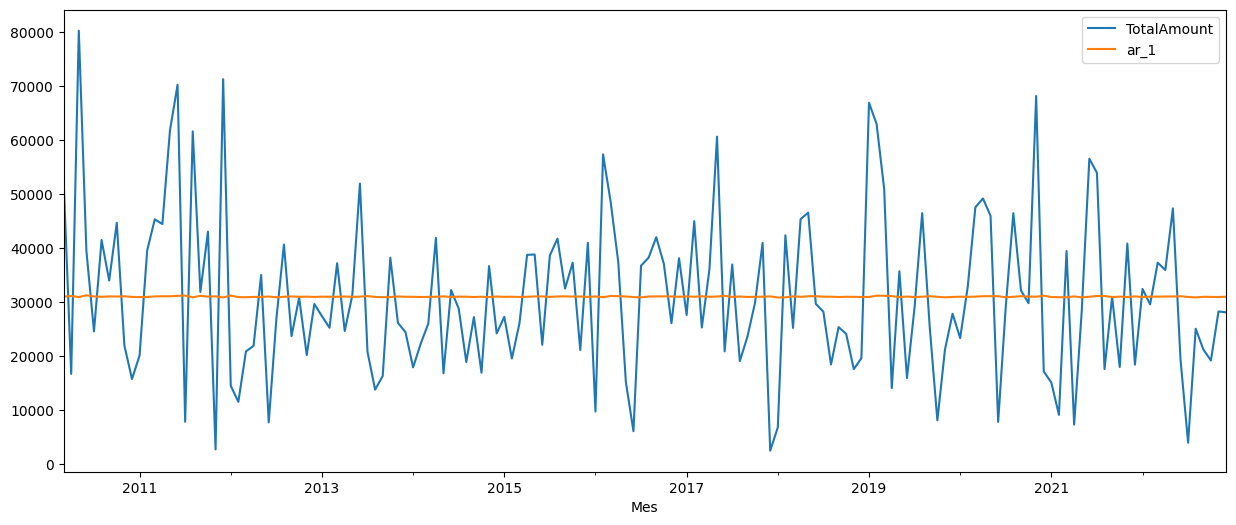

In [414]:
df_predict = ts_sales_mes.copy()
df_predict['ar_1'] = y_pred
df_predict[['TotalAmount','ar_1']].plot(figsize=(15,6))

## All Results

In [415]:
results = pd.concat([naive_metrics, lr_metrics])
results.sort_values('RMSE', ascending=True)

,Algorithm,MAE,RMSE,R2
0,linear regression,11904.410255,14990.271784,0.000027
0,naive model,15970.946774,21100.547723,-0.994176
